## Jupyter Notebook Sample


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv('data/bank-additional/bank-additional-full.csv')
data.head()


age;"job";"marital";"education";"default";"housing";"loan";"contact";"month";"day_of_week";"duration";"campaign";"pdays";"previous";"poutcome";"emp.var.rate";"cons.price.idx";"cons.conf.idx";"euribor3m";"nr.employed";"y"
0  56;"housemaid";"married";"basic.4y";"no";"no";...                                                                                                                                                                          
1  57;"services";"married";"high.school";"unknown...                                                                                                                                                                          
2  37;"services";"married";"high.school";"no";"ye...                                                                                                                                                                          
3  40;"admin.";"married";"basic.6y";"no";"no";"no...                                                                                                                                                                          
4  56;"services";"married";"high.school";"no";"no...

### 数据加载（分号分隔）
原文件使用分号作为分隔符，需显式设置 `sep=';'` 并处理引号。

In [2]:
import pandas as pd
import numpy as np

# 重新读取：分号分隔、双引号包裹字段
data = pd.read_csv('data/bank-additional/bank-additional-full.csv', sep=';', quotechar='"')

print(f"列数: {data.shape[1]}")
print(data.columns.tolist())
data.head()
data.to_csv('data/bank-additional/bank-additional-full-processed.csv', index=False)

列数: 21
['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']


In [3]:
data['y'].value_counts()

y
no     36548
yes     4640
Name: count, dtype: int64

In [4]:
# 检查所有列的NaN值数量
print("各列缺失值统计：")
print(data.isnull().sum())
print(f"\n总缺失值数量: {data.isnull().sum().sum()}")
print(f"数据集总行数: {len(data)}")

各列缺失值统计：
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

总缺失值数量: 0
数据集总行数: 41188


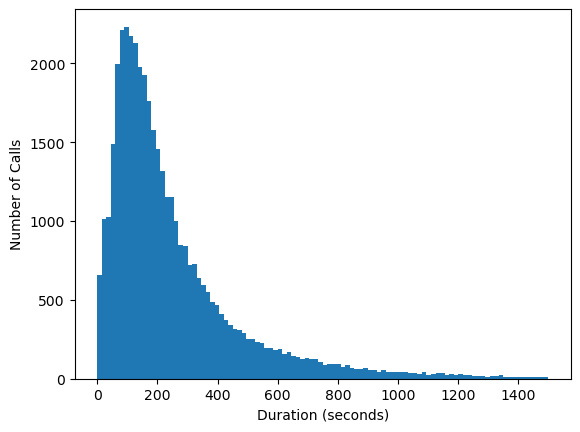

In [5]:
plt.hist(data[data['duration'] < 1500]['duration'], bins=100)
plt.xlabel('Duration (seconds)') 
plt.ylabel('Number of Calls')
plt.show()

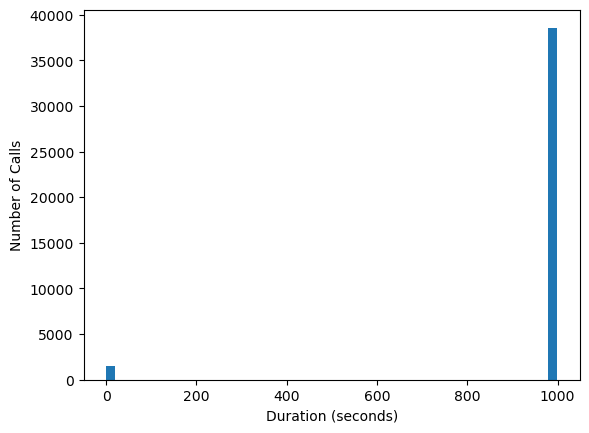

In [6]:
plt.hist(data[data['campaign'] < 10]['pdays'], bins=50)
plt.xlabel('Duration (seconds)') 
plt.ylabel('Number of Calls')
plt.show()

## 原始的变量说明表


| Variable Name | Type | Demographic | Description | Missing Values |
| --- | --- | --- | --- | --- |
| age | Integer | Age | Age (years) | no |
| job | Categorical | Occupation | admin./blue-collar/entrepreneur/housemaid/management/retired/self-employed/services/student/technician/unemployed/unknown | no |
| marital | Categorical | Marital Status | divorced/married/single/unknown | no |
| education | Categorical | Education Level | basic.4y/basic.6y/basic.9y/high.school/illiterate/professional.course/university.degree/unknown | no |
| default | Binary |  | Credit in default | no |
| balance | Integer |  | Average yearly balance (euros) | no |
| housing | Binary |  | Has housing loan | no |
| loan | Binary |  | Has personal loan | no |
| contact | Categorical |  | Contact type (cellular/telephone) | yes |
| day_of_week | Date |  | Last contact day of week | no |
| month | Date |  | Last contact month (jan-dec) | no |
| duration | Integer |  | Last contact duration (seconds) — benchmarking only | no |
| campaign | Integer |  | Number of contacts in this campaign | no |
| pdays | Integer |  | Days since last contact from previous campaign (-1 means not previously contacted) | yes |
| previous | Integer |  | Contacts before this campaign | no |
| poutcome | Categorical |  | Outcome of previous campaign (failure/nonexistent/success) | yes |
| emp.var.rate | Float |  | Employment variation rate | no |
| cons.price.idx | Float |  | Consumer Price Index | no |
| euribor3m | Float |  | Market Base Interest Rate | no |
| nr.employed | Float |  | Number of Employed in Portugal | no |
| y (target) | Binary |  | Client subscribed term deposit | no |


## 数据预处理

In [7]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (roc_auc_score, accuracy_score, classification_report,
                            precision_score, recall_score, confusion_matrix)
from sklearn.metrics import make_scorer
# 1. 准备数据
# 假设df是您的DataFrame
X = data.drop('y', axis=1)
X = X.drop(['month', 'day_of_week'], axis=1)  # 删除duration列
y = data['y'].map({'yes': 1, 'no': 0})  # 转为1和0

# 2. 转换月份和星期几为数值（如果需要）
if 'month' in X.columns:
    month_map = {
        'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
        'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
    }
    X['month'] = X['month'].map(month_map)

elif 'day_of_week' in X.columns:
    weekday_map = {
        'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5, 'sat': 6, 'sun': 7
    }

    # 应用转换
    X['day_of_week'] = X['day_of_week'].map(weekday_map)

# 3. 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2, stratify=y
)

# 4. 指定类别特征
categorical_features = ['job', 'marital', 'education', 'default', 
                        'housing', 'loan', 'contact', 'poutcome']

# 确保这些特征被正确处理为category类型
for col in categorical_features:
    X_train[col] = X_train[col].astype(str).astype('category')
    X_test[col] = X_test[col].astype(str).astype('category')

# 5. 检查数据类型
print("训练集数据类型:")
print(X_train.dtypes)
print("\n测试集数据类型:")
print(X_test.dtypes)

# 6. 创建LightGBM数据集
train_data = lgb.Dataset(
    X_train, 
    label=y_train,
    categorical_feature=categorical_features,
    free_raw_data=False
)

# 7. 设置参数
params = {
    # 基础参数
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    
    # 控制复杂度
    'num_leaves': 31,
    'max_depth': -1,
    'min_child_samples': 20,
    
    # 学习率
    'learning_rate': 0.05,
    
    # 正则化
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    
    # 处理不平衡数据
    'is_unbalance': True,
    
    'verbose': -1,
}

# 8. 训练模型
num_round = 1000

print("开始训练LightGBM模型...")
model = lgb.train(
    params,
    train_data,
    num_boost_round=num_round,
    valid_sets=[train_data],
    callbacks=[
        lgb.early_stopping(50, verbose=True),
        lgb.log_evaluation(100)
    ]
)

sigma = 0.5
# 9. 预测
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > sigma).astype(int)

# 10. 评估
print("\n=== 模型评估 ===")
print(f"AUC Score: {roc_auc_score(y_test, y_pred_prob):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"正样本比例: {y.mean():.2%}")
print(f"预测正样本比例: {y_pred.mean():.2%}")

print("\n分类报告:")
print(classification_report(y_test, y_pred))

# 11. 特征重要性分析
importance = pd.DataFrame({
    'feature': model.feature_name(),
    'importance': model.feature_importance(importance_type='gain')
})
importance = importance.sort_values('importance', ascending=False)

print("\n=== 特征重要性 Top 15 ===")
print(importance.head(15))

训练集数据类型:
age                  int64
job               category
marital           category
education         category
default           category
housing           category
loan              category
contact           category
duration             int64
campaign             int64
pdays                int64
previous             int64
poutcome          category
emp.var.rate       float64
cons.price.idx     float64
cons.conf.idx      float64
euribor3m          float64
nr.employed        float64
dtype: object

测试集数据类型:
age                  int64
job               category
marital           category
education         category
default           category
housing           category
loan              category
contact           category
duration             int64
campaign             int64
pdays                int64
previous             int64
poutcome          category
emp.var.rate       float64
cons.price.idx     float64
cons.conf.idx      float64
euribor3m          float64
nr.employed        flo

d:\anaconda3\Lib\site-packages\lightgbm\callback.py:347: UserWarning: Only training set found, disabling early stopping.
  _log_warning("Only training set found, disabling early stopping.")


[100]	training's auc: 0.961092
[200]	training's auc: 0.970548
[300]	training's auc: 0.97775
[400]	training's auc: 0.983014
[500]	training's auc: 0.987242
[600]	training's auc: 0.990464
[700]	training's auc: 0.992834
[800]	training's auc: 0.994832
[900]	training's auc: 0.996211
[1000]	training's auc: 0.997282

=== 模型评估 ===
AUC Score: 0.9465
Accuracy: 0.8991
正样本比例: 11.27%
预测正样本比例: 16.96%

分类报告:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      7310
           1       0.53      0.80      0.64       928

    accuracy                           0.90      8238
   macro avg       0.75      0.86      0.79      8238
weighted avg       0.92      0.90      0.91      8238


=== 特征重要性 Top 15 ===
           feature     importance
8         duration  242437.355345
16       euribor3m   80281.676003
13    emp.var.rate   60382.150954
17     nr.employed   47630.519003
0              age   40397.449985
15   cons.conf.idx   22119.684152
14  cons.price.id

In [10]:
def custom_scorer(y_true, y_pred_prob):
    """GridSearchCV专用评分函数，返回 recall² × precision"""
    # 用0.5阈值临时计算（最终阈值后续单独优化）
    y_pred = (y_pred_prob > 0.5).astype(int)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    epsilon = 1e-10  # 避免0值导致乘积为0
    return (recall + epsilon)**2 * (precision + epsilon)

def custom_score_financially(y_true, y_pred_prob, contact_cost=1, subscription_value=5):
    """
    优化版：计算基于业务收益的净利润得分，适配所有样本分布，支持动态阈值
    
    参数：
    - y_true: 真实标签
    - y_pred_prob: 预测概率（无需提前指定阈值）
    - contact_cost: 单次电话触达成本（默认1）
    - subscription_value: 单次认购的收益（默认5）
    返回：
    - 最大净利润（全局最优，而非固定阈值）
    """
    # 1. 动态搜索最优阈值（遍历0.01-0.99，找到净利润最大的阈值）
    thresholds = np.linspace(0.01, 0.99, 99)
    net_profits = []
    
    for thresh in thresholds:
        y_pred = (y_pred_prob > thresh).astype(int)
        # 关键优化：指定labels=[0,1]，避免ravel()报错
        cm = confusion_matrix(y_true, y_pred, labels=[0,1])
        tn, fp, fn, tp = cm.ravel()
        
        # 核心计算：净利润 = 认购收益 - 触达成本
        total_revenue = tp * subscription_value
        total_cost = (tp + fp) * contact_cost  # 只有预测为正的才会触达，产生成本
        # 可选：纳入FN的机会成本（本来能赚却没赚的钱）
        # opportunity_cost = fn * subscription_value
        # net_profit = total_revenue - total_cost - opportunity_cost
        net_profit = total_revenue - total_cost
        net_profits.append(net_profit)
    
    # 返回最大净利润（全局最优）
    max_net_profit = max(net_profits)
    return max_net_profit

# 2. 定义参数网格（重点优化3类目标参数）
param_grid = {
    'num_leaves': [31],  # 控制树复杂度，避免过拟合（不超过2^max_depth）
    'learning_rate': [0.005, 0.01, 0.02],  # 学习率，小值更稳定但需更多迭代
    'reg_alpha': [0.5, 1.0, 2.0],  # L1正则化，抑制过拟合
    'reg_lambda': [0.005, 0.01, 0.02],  # L2正则化，提升模型稳定性
    'n_estimators': [1000],
    'max_depth': [-1],
    'min_child_samples': [20],
    'feature_fraction': [0.8],
    'bagging_fraction': [0.8],
    'bagging_freq': [5],
    'is_unbalance': [True],
    'verbose': [-1]
}

# 3. 初始化LightGBM分类器（适配sklearn接口）
lgb_clf = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    boosting_type='gbdt',
    categorical_feature=categorical_features  # 指定类别特征
)

# 4. 分层交叉验证（适配类别不平衡）
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)


以下的格子采用不同的评分函数，
+ 第一个cell：$L = 2\log(recall_1) + \log(precision_1)$
+ 第二个cell: $L = 5 \times TP - 1\times(TP + FP)$

选择一个继续

## V1

In [ ]:
# 5. 网格搜索（用自定义评分函数）
print("开始网格搜索优化超参数...")
grid_search = GridSearchCV(
    estimator=lgb_clf,
    param_grid=param_grid,
    scoring=make_scorer(custom_scorer, response_method='predict_proba'), # 需预测概率
    cv=cv,
    n_jobs=-1,  # 利用所有CPU核心加速
    verbose=1,
    refit=True  # 用最优参数重新训练完整训练集
)

# 执行网格搜索
grid_search.fit(X_train, y_train)

# 输出最优结果
print("\n" + "="*60)
print("网格搜索最优结果：")
print(f"最优超参数：{grid_search.best_params_}")
print(f"最优评分（recall²×precision）：{grid_search.best_score_:.4f}")
print("="*60)

# 6. 用最优参数获取最终模型
best_model = grid_search.best_estimator_

# 7. 预测、评估、阈值优化、分析
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > sigma).astype(int)

print("\n=== 模型评估 ===")
print(f"AUC Score: {roc_auc_score(y_test, y_pred_prob):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"正样本比例: {y.mean():.2%}")
print(f"预测正样本比例: {y_pred.mean():.2%}")

print("\n分类报告:")
print(classification_report(y_test, y_pred))

importance = pd.DataFrame({
    'feature': model.feature_name(),
    'importance': model.feature_importance(importance_type='gain')
})
importance = importance.sort_values('importance', ascending=False)

print("\n=== 特征重要性 Top 15 ===")
print(importance.head(15))

最优阈值: 0.2600
最优指标值 (recall²×precision): 0.3866
在该阈值下的精确率: 0.4696
在该阈值下的召回率: 0.9073
在该阈值下的F1分数: 0.6189

使用最优阈值的业务影响:
总客户数: 8238
预测为认购的客户数: 1793 (21.8%)
实际认购客户数: 928
成功找到的认购客户: 842 (命中率: 47.0%)
漏掉的认购客户: 86 (漏掉率: 9.3%)


C:\Users\20249\AppData\Local\Temp\ipykernel_68212\1984657281.py:163: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from current font.
  plt.tight_layout()
d:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


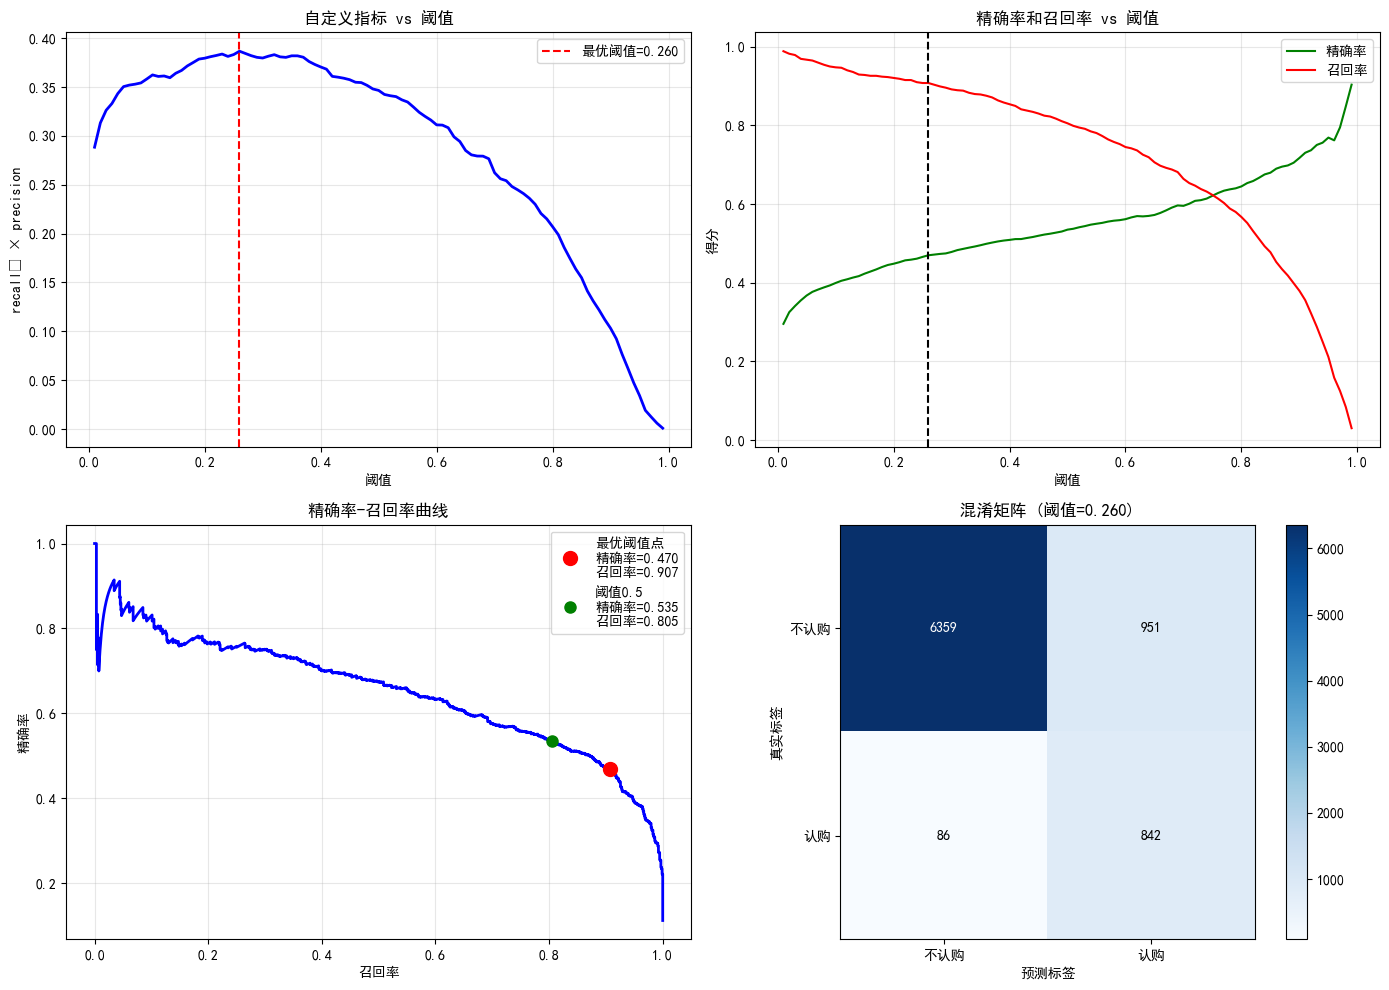

业务决策建议
建议阈值: 0.260

营销活动预测:
  总客户数: 8238
  建议联系的客户数: 1793 (21.8%)
  预计成功认购数: 842 (命中率: 47.0%)
  预计漏掉的认购客户: 86 (覆盖率: 90.7%)

财务预测:
  总联系成本: ￥17930 (单价: ￥10/人)
  总认购收益: ￥421000 (单价: ￥500/人)
  净利润: ￥403070
  单客户获取成本: ￥21.3
  投资回报率: 2248.0%


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (precision_score, recall_score, f1_score, 
                            precision_recall_curve, auc, confusion_matrix,
                            classification_report)
from sklearn.model_selection import train_test_split

plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows系统默认黑体（无需额外安装）
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

# 1. 定义寻找最优阈值的函数
def find_optimal_threshold_custom(y_true, y_pred_prob, beta=2):
    """
    寻找最大化 recall^beta * precision 的最优阈值
    """
    thresholds = np.linspace(0.01, 0.99, 99)
    
    scores = []
    precisions = []
    recalls = []
    f1_scores = []
    
    for thresh in thresholds:
        y_pred = (y_pred_prob > thresh).astype(int)
        
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        
        epsilon = 1e-10
        custom_score = (recall + epsilon)**beta * (precision + epsilon)
        
        scores.append(custom_score)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
    
    optimal_idx = np.argmax(scores)
    optimal_threshold = thresholds[optimal_idx]
    optimal_score = scores[optimal_idx]
    
    metrics_dict = {
        'thresholds': thresholds,
        'custom_scores': scores,
        'precisions': precisions,
        'recalls': recalls,
        'f1_scores': f1_scores,
        'optimal_threshold': optimal_threshold,
        'optimal_precision': precisions[optimal_idx],
        'optimal_recall': recalls[optimal_idx],
        'optimal_f1': f1_scores[optimal_idx],
        'optimal_custom_score': optimal_score
    }
    
    return optimal_threshold, optimal_score, metrics_dict

# 2. 寻找最优阈值
optimal_thresh, optimal_score, metrics_dict = find_optimal_threshold_custom(
    y_test, y_pred_prob, beta=2
)

print("=" * 60)
print(f"最优阈值: {optimal_thresh:.4f}")
print(f"最优指标值 (recall²×precision): {optimal_score:.4f}")
print(f"在该阈值下的精确率: {metrics_dict['optimal_precision']:.4f}")
print(f"在该阈值下的召回率: {metrics_dict['optimal_recall']:.4f}")
print(f"在该阈值下的F1分数: {metrics_dict['optimal_f1']:.4f}")

# 3. 使用最优阈值重新预测
y_pred_optimal = (y_pred_prob > optimal_thresh).astype(int)

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred_optimal)
tn, fp, fn, tp = cm.ravel()

print("\n" + "=" * 60)
print("使用最优阈值的业务影响:")
print(f"总客户数: {len(y_test)}")
print(f"预测为认购的客户数: {tp + fp} ({((tp+fp)/len(y_test)*100):.1f}%)")
print(f"实际认购客户数: {tp + fn}")
print(f"成功找到的认购客户: {tp} (命中率: {tp/(tp+fp)*100:.1f}%)")
print(f"漏掉的认购客户: {fn} (漏掉率: {fn/(tp+fn)*100:.1f}%)")

# 4. 绘制可视化分析
def plot_custom_metric_analysis(metrics_dict, y_true, y_pred_prob):
    """绘制自定义指标的分析图"""
    

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. 自定义指标 vs 阈值
    ax = axes[0, 0]
    ax.plot(metrics_dict['thresholds'], metrics_dict['custom_scores'], 'b-', linewidth=2)
    ax.axvline(x=metrics_dict['optimal_threshold'], color='r', linestyle='--', 
               label=f'最优阈值={metrics_dict["optimal_threshold"]:.3f}')
    ax.set_xlabel('阈值')
    ax.set_ylabel('recall² × precision')
    ax.set_title('自定义指标 vs 阈值')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. 精确率和召回率 vs 阈值
    ax = axes[0, 1]
    ax.plot(metrics_dict['thresholds'], metrics_dict['precisions'], 'g-', label='精确率')
    ax.plot(metrics_dict['thresholds'], metrics_dict['recalls'], 'r-', label='召回率')
    ax.axvline(x=metrics_dict['optimal_threshold'], color='k', linestyle='--')
    ax.set_xlabel('阈值')
    ax.set_ylabel('得分')
    ax.set_title('精确率和召回率 vs 阈值')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. 精确率-召回率曲线，标记不同阈值
    ax = axes[1, 0]
    precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_true, y_pred_prob)
    
    ax.plot(recall_curve, precision_curve, 'b-', linewidth=2)
    ax.set_xlabel('召回率')
    ax.set_ylabel('精确率')
    ax.set_title('精确率-召回率曲线')
    ax.grid(True, alpha=0.3)
    
    # 在PR曲线上标记最优阈值点
    optimal_precision = metrics_dict['optimal_precision']
    optimal_recall = metrics_dict['optimal_recall']
    ax.plot(optimal_recall, optimal_precision, 'ro', markersize=10, 
            label=f'最优阈值点\n精确率={optimal_precision:.3f}\n召回率={optimal_recall:.3f}')
    
    # 标记传统阈值0.5
    y_pred_05 = (y_pred_prob > 0.5).astype(int)
    precision_05 = precision_score(y_true, y_pred_05, zero_division=0)
    recall_05 = recall_score(y_true, y_pred_05, zero_division=0)
    ax.plot(recall_05, precision_05, 'go', markersize=8, 
            label=f'阈值0.5\n精确率={precision_05:.3f}\n召回率={recall_05:.3f}')
    
    ax.legend()
    
    # 4. 混淆矩阵热力图
    ax = axes[1, 1]
    y_pred_optimal = (y_pred_prob > metrics_dict['optimal_threshold']).astype(int)
    cm = confusion_matrix(y_true, y_pred_optimal)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # 添加数值标签
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                   ha="center", va="center",
                   color="white" if cm[i, j] > thresh else "black")
    
    ax.set_xlabel('预测标签')
    ax.set_ylabel('真实标签')
    ax.set_title(f'混淆矩阵 (阈值={metrics_dict["optimal_threshold"]:.3f})')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['不认购', '认购'])
    ax.set_yticklabels(['不认购', '认购'])
    
    plt.tight_layout()
    plt.show()

# 5. 绘制分析图
plot_custom_metric_analysis(metrics_dict, y_test, y_pred_prob)

# 6. 提供业务建议
def business_recommendation(y_true, y_pred_prob, optimal_threshold, 
                           contact_cost=1, subscription_value=5):
    """
    根据最优阈值提供业务建议
    """
    y_pred = (y_pred_prob > optimal_threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    total_clients = len(y_true)
    predicted_yes = tp + fp
    actual_yes = tp + fn
    
    hit_rate = tp / predicted_yes if predicted_yes > 0 else 0
    coverage = tp / actual_yes if actual_yes > 0 else 0
    
    total_cost = predicted_yes * contact_cost
    total_revenue = tp * subscription_value
    net_profit = total_revenue - total_cost
    
    cost_per_acquisition = total_cost / tp if tp > 0 else float('inf')
    roi = net_profit / total_cost if total_cost > 0 else 0
    
    print("=" * 60)
    print("业务决策建议")
    print("=" * 60)
    print(f"建议阈值: {optimal_threshold:.3f}")
    print(f"\n营销活动预测:")
    print(f"  总客户数: {total_clients}")
    print(f"  建议联系的客户数: {predicted_yes} ({predicted_yes/total_clients*100:.1f}%)")
    print(f"  预计成功认购数: {tp} (命中率: {hit_rate*100:.1f}%)")
    print(f"  预计漏掉的认购客户: {fn} (覆盖率: {coverage*100:.1f}%)")
    
    print(f"\n财务预测:")
    print(f"  总联系成本: ￥{total_cost:.0f} (单价: ￥{contact_cost}/人)")
    print(f"  总认购收益: ￥{total_revenue:.0f} (单价: ￥{subscription_value}/人)")
    print(f"  净利润: ￥{net_profit:.0f}")
    print(f"  单客户获取成本: ￥{cost_per_acquisition:.1f}")
    print(f"  投资回报率: {roi*100:.1f}%")
    
    return {
        'threshold': optimal_threshold,
        'predicted_contacts': predicted_yes,
        'expected_success': tp,
        'hit_rate': hit_rate,
        'coverage': coverage,
        'net_profit': net_profit,
        'roi': roi
    }

# 提供业务建议
business_metrics = business_recommendation(
    y_test, y_pred_prob, optimal_thresh,
    contact_cost=10, subscription_value=50
)

## V2

In [15]:
# 网格搜索部分的核心修改
grid_search = GridSearchCV(
    estimator=lgb_clf,
    param_grid=param_grid,
    # 用财务评分函数替代原有函数，指定response_method=predict_proba
    scoring=make_scorer(custom_score_financially, 
                        response_method='predict_proba',
                        contact_cost=1,  # 可根据实际业务调整
                        subscription_value=10),  # 可根据实际业务调整
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

# 执行网格搜索
grid_search.fit(X_train, y_train)

# 输出最优结果
print("\n" + "="*60)
print("网格搜索最优结果：")
print(f"最优超参数：{grid_search.best_params_}")
print(f"最优评分（净利润）：{grid_search.best_score_:.4f}")
print("="*60)

# 6. 用最优参数获取最终模型
best_model = grid_search.best_estimator_

# 7. 预测、评估、阈值优化、分析
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > sigma).astype(int)

print("\n=== 模型评估 ===")
print(f"AUC Score: {roc_auc_score(y_test, y_pred_prob):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"正样本比例: {y.mean():.2%}")
print(f"预测正样本比例: {y_pred.mean():.2%}")

print("\n分类报告:")
print(classification_report(y_test, y_pred))

importance = pd.DataFrame({
    'feature': model.feature_name(),
    'importance': model.feature_importance(importance_type='gain')
})
importance = importance.sort_values('importance', ascending=False)

print("\n=== 特征重要性 Top 15 ===")
print(importance.head(15))

Fitting 5 folds for each of 27 candidates, totalling 135 fits


d:\anaconda3\Lib\site-packages\lightgbm\basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
d:\anaconda3\Lib\site-packages\lightgbm\basic.py:2159: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")



网格搜索最优结果：
最优超参数：{'bagging_fraction': 0.8, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': True, 'learning_rate': 0.005, 'max_depth': -1, 'min_child_samples': 20, 'n_estimators': 1000, 'num_leaves': 31, 'reg_alpha': 2.0, 'reg_lambda': 0.005, 'verbose': -1}
最优评分（净利润）：5416.4000

=== 模型评估 ===
AUC Score: 0.9465
Accuracy: 0.8991
正样本比例: 11.27%
预测正样本比例: 16.96%

分类报告:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      7310
           1       0.53      0.80      0.64       928

    accuracy                           0.90      8238
   macro avg       0.75      0.86      0.79      8238
weighted avg       0.92      0.90      0.91      8238


=== 特征重要性 Top 15 ===
           feature     importance
8         duration  242437.355345
16       euribor3m   80281.676003
13    emp.var.rate   60382.150954
17     nr.employed   47630.519003
0              age   40397.449985
15   cons.conf.idx   22119.684152
14  cons.price.idx   20363.496831
9   

财务最优阈值: 0.2300
最大净利润: ￥6638.00
在该阈值下的精确率: 0.4584
在该阈值下的召回率: 0.9149
在该阈值下的F1分数: 0.6108

使用财务最优阈值的业务影响:
总客户数: 8238
预测为认购的客户数: 1852 (22.5%)
实际认购客户数: 928
成功找到的认购客户: 849 (命中率: 45.8%)
漏掉的认购客户: 79 (漏掉率: 8.5%)


C:\Users\20249\AppData\Local\Temp\ipykernel_68212\3441551658.py:116: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(metrics_dict['thresholds'], metrics_dict['net_profits'], 'b-', linewidth=2, color='#1f77b4')
C:\Users\20249\AppData\Local\Temp\ipykernel_68212\3441551658.py:127: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-" (-> color='g'). The keyword argument will take precedence.
  ax.plot(metrics_dict['thresholds'], metrics_dict['precisions'], 'g-', label='精确率', color='#2ca02c')
C:\Users\20249\AppData\Local\Temp\ipykernel_68212\3441551658.py:128: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(metrics_dict['thresholds'], metrics_dict['recalls'], 'r-', label='召回率', color='#d62728')
C:\Users\20249\App

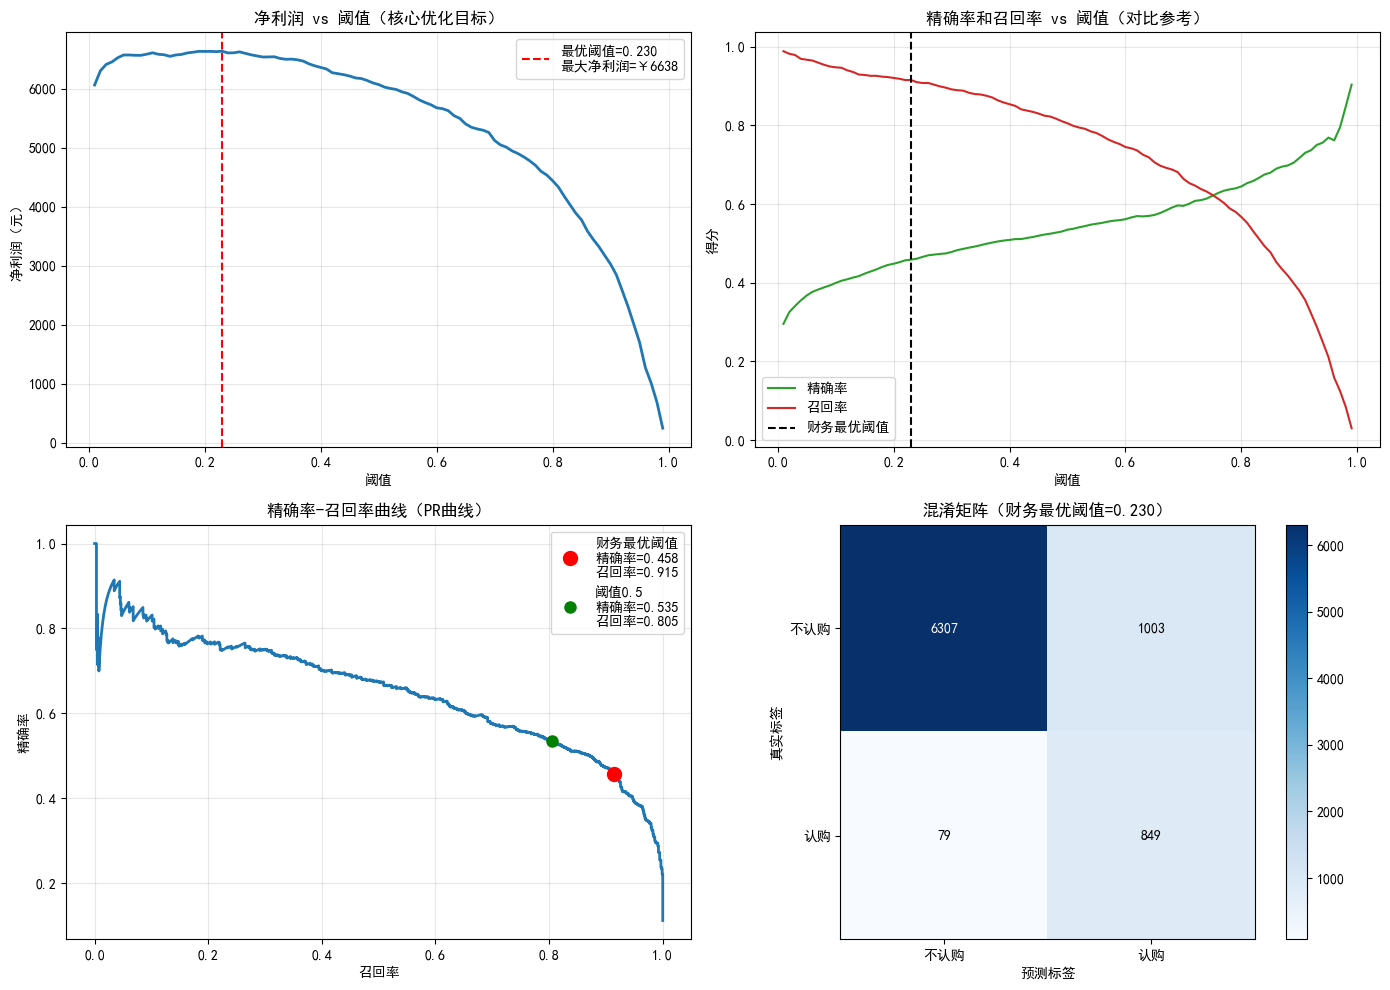

📊 基于财务最优阈值的业务决策建议
✅ 核心建议阈值: 0.230

📈 营销效率分析:
  总客户数: 8,238
  建议联系的客户数: 1,852 (22.5%)
  实际认购客户数: 928 (11.3%)
  成功转化数: 849 (命中率: 45.8%)
  漏掉的认购客户: 79 (覆盖率: 91.5%)

💰 财务收益分析:
  单次电话成本: ￥1 | 单次认购收益: ￥10
  总联系成本: ￥1,852
  总认购收益: ￥8,490
  净利润: ￥6,638 (ROI: 358.4%)
  单客户获取成本: ￥2.2
  漏掉的潜在收益: ￥790 (可通过降低阈值减少)

💡 行动建议:
  ✅ 当前阈值下ROI为正，可按此阈值执行营销触达


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (precision_score, recall_score, f1_score, 
                            precision_recall_curve, confusion_matrix,
                            classification_report)

# ---------------------- 1. 重构：寻找财务最优阈值（核心修改） ----------------------
def find_optimal_threshold_financial(y_true, y_pred_prob, contact_cost=1, subscription_value=10):
    """
    寻找最大化「净利润」的最优阈值
    参数：
    - y_true: 真实标签
    - y_pred_prob: 预测概率
    - contact_cost: 单次电话触达成本（默认1元）
    - subscription_value: 单次认购的收益（默认5元）
    返回：
    - 最优阈值、最大净利润、全量指标字典
    """
    thresholds = np.linspace(0.01, 0.99, 99)
    
    # 存储各阈值下的指标
    net_profits = []  # 核心：净利润
    precisions = []
    recalls = []
    f1_scores = []
    
    for thresh in thresholds:
        y_pred = (y_pred_prob > thresh).astype(int)
        
        # 关键修复：指定labels=[0,1]，避免混淆矩阵维度错误
        cm = confusion_matrix(y_true, y_pred, labels=[0,1])
        tn, fp, fn, tp = cm.ravel()
        
        # 计算财务指标
        total_revenue = tp * subscription_value  # 总认购收益
        total_cost = (tp + fp) * contact_cost    # 总触达成本（仅预测为认购的才触达）
        net_profit = total_revenue - total_cost  # 净利润
        
        # 计算传统指标（保留，用于对比）
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        
        # 存入列表
        net_profits.append(net_profit)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
    
    # 找到净利润最大的阈值
    optimal_idx = np.argmax(net_profits)
    optimal_threshold = thresholds[optimal_idx]
    max_net_profit = net_profits[optimal_idx]
    
    # 构建指标字典（适配原有可视化逻辑）
    metrics_dict = {
        'thresholds': thresholds,
        'net_profits': net_profits,          # 新增：净利润列表
        'custom_scores': net_profits,        # 兼容原有代码：用净利润替代原custom_score
        'precisions': precisions,
        'recalls': recalls,
        'f1_scores': f1_scores,
        'optimal_threshold': optimal_threshold,
        'optimal_precision': precisions[optimal_idx],
        'optimal_recall': recalls[optimal_idx],
        'optimal_f1': f1_scores[optimal_idx],
        'optimal_net_profit': max_net_profit  # 新增：最优净利润
    }
    
    return optimal_threshold, max_net_profit, metrics_dict

# ---------------------- 2. 调用函数：寻找财务最优阈值 ----------------------
# 注意：这里的y_test/y_pred_prob需要是你模型输出的真实变量
# （需确保前置代码已生成这两个变量）
optimal_thresh, max_net_profit, metrics_dict = find_optimal_threshold_financial(
    y_test, y_pred_prob,
    contact_cost=1,    # 可根据实际业务调整（比如单次电话成本1元）
    subscription_value=10  # 可根据实际调整（比如单次认购收益10元）
)

# 打印核心结果
print("=" * 60)
print(f"财务最优阈值: {optimal_thresh:.4f}")
print(f"最大净利润: ￥{max_net_profit:.2f}")
print(f"在该阈值下的精确率: {metrics_dict['optimal_precision']:.4f}")
print(f"在该阈值下的召回率: {metrics_dict['optimal_recall']:.4f}")
print(f"在该阈值下的F1分数: {metrics_dict['optimal_f1']:.4f}")

# 3. 使用最优阈值重新预测（输出业务影响）
y_pred_optimal = (y_pred_prob > optimal_thresh).astype(int)

# 计算混淆矩阵（修复版）
cm = confusion_matrix(y_test, y_pred_optimal, labels=[0,1])
tn, fp, fn, tp = cm.ravel()

print("\n" + "=" * 60)
print("使用财务最优阈值的业务影响:")
print(f"总客户数: {len(y_test)}")
print(f"预测为认购的客户数: {tp + fp} ({((tp+fp)/len(y_test)*100):.1f}%)")
print(f"实际认购客户数: {tp + fn}")
print(f"成功找到的认购客户: {tp} (命中率: {tp/(tp+fp)*100:.1f}%)")
print(f"漏掉的认购客户: {fn} (漏掉率: {fn/(tp+fn)*100:.1f}%)")

# ---------------------- 4. 重构：可视化分析函数（适配财务指标） ----------------------
def plot_financial_metric_analysis(metrics_dict, y_true, y_pred_prob):
    """绘制以净利润为核心的可视化分析图（替代原plot_custom_metric_analysis）"""
    # 解决中文字体显示问题（必加）
    plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows黑体
    plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. 净利润 vs 阈值（核心图表）
    ax = axes[0, 0]
    ax.plot(metrics_dict['thresholds'], metrics_dict['net_profits'], 'b-', linewidth=2, color='#1f77b4')
    ax.axvline(x=metrics_dict['optimal_threshold'], color='r', linestyle='--', 
               label=f'最优阈值={metrics_dict["optimal_threshold"]:.3f}\n最大净利润=￥{metrics_dict["optimal_net_profit"]:.0f}')
    ax.set_xlabel('阈值')
    ax.set_ylabel('净利润（元）')
    ax.set_title('净利润 vs 阈值（核心优化目标）')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. 精确率和召回率 vs 阈值（对比用）
    ax = axes[0, 1]
    ax.plot(metrics_dict['thresholds'], metrics_dict['precisions'], 'g-', label='精确率', color='#2ca02c')
    ax.plot(metrics_dict['thresholds'], metrics_dict['recalls'], 'r-', label='召回率', color='#d62728')
    ax.axvline(x=metrics_dict['optimal_threshold'], color='k', linestyle='--', label='财务最优阈值')
    ax.set_xlabel('阈值')
    ax.set_ylabel('得分')
    ax.set_title('精确率和召回率 vs 阈值（对比参考）')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. 精确率-召回率曲线（标记关键阈值）
    ax = axes[1, 0]
    precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_true, y_pred_prob)
    ax.plot(recall_curve, precision_curve, 'b-', linewidth=2, color='#1f77b4')
    ax.set_xlabel('召回率')
    ax.set_ylabel('精确率')
    ax.set_title('精确率-召回率曲线（PR曲线）')
    ax.grid(True, alpha=0.3)
    
    # 标记财务最优阈值点
    optimal_precision = metrics_dict['optimal_precision']
    optimal_recall = metrics_dict['optimal_recall']
    ax.plot(optimal_recall, optimal_precision, 'ro', markersize=10, 
            label=f'财务最优阈值\n精确率={optimal_precision:.3f}\n召回率={optimal_recall:.3f}')
    
    # 标记传统阈值0.5（对比）
    y_pred_05 = (y_pred_prob > 0.5).astype(int)
    precision_05 = precision_score(y_true, y_pred_05, zero_division=0)
    recall_05 = recall_score(y_true, y_pred_05, zero_division=0)
    ax.plot(recall_05, precision_05, 'go', markersize=8, 
            label=f'阈值0.5\n精确率={precision_05:.3f}\n召回率={recall_05:.3f}')
    ax.legend()
    
    # 4. 混淆矩阵热力图（修复版）
    ax = axes[1, 1]
    y_pred_optimal = (y_pred_prob > metrics_dict['optimal_threshold']).astype(int)
    cm = confusion_matrix(y_true, y_pred_optimal, labels=[0,1])
    
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # 添加数值标签
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                   ha="center", va="center",
                   color="white" if cm[i, j] > thresh else "black")
    
    ax.set_xlabel('预测标签')
    ax.set_ylabel('真实标签')
    ax.set_title(f'混淆矩阵（财务最优阈值={metrics_dict["optimal_threshold"]:.3f}）')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['不认购', '认购'])
    ax.set_yticklabels(['不认购', '认购'])
    
    plt.tight_layout()
    plt.show()

# ---------------------- 5. 绘制财务导向的可视化图表 ----------------------
plot_financial_metric_analysis(metrics_dict, y_test, y_pred_prob)

# ---------------------- 6. 优化：业务建议函数（更贴合财务目标） ----------------------
def business_recommendation_financial(y_true, y_pred_prob, optimal_threshold, 
                                     contact_cost=1, subscription_value=5):
    """
    基于财务最优阈值的业务建议（增强版）
    """
    y_pred = (y_pred_prob > optimal_threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    
    total_clients = len(y_true)
    predicted_yes = tp + fp  # 建议联系的客户数
    actual_yes = tp + fn     # 实际认购客户数
    
    # 核心业务指标
    hit_rate = tp / predicted_yes if predicted_yes > 0 else 0  # 命中率（精确率）
    coverage = tp / actual_yes if actual_yes > 0 else 0        # 覆盖率（召回率）
    missed_opportunity = fn * subscription_value                # 漏掉的收益（机会成本）
    
    # 核心财务指标
    total_cost = predicted_yes * contact_cost
    total_revenue = tp * subscription_value
    net_profit = total_revenue - total_cost
    cost_per_acquisition = total_cost / tp if tp > 0 else float('inf')  # 单客户获取成本
    roi = (net_profit / total_cost) * 100 if total_cost > 0 else 0      # 投资回报率（%）
    
    # 输出建议
    print("=" * 80)
    print("📊 基于财务最优阈值的业务决策建议")
    print("=" * 80)
    print(f"✅ 核心建议阈值: {optimal_threshold:.3f}")
    print(f"\n📈 营销效率分析:")
    print(f"  总客户数: {total_clients:,}")
    print(f"  建议联系的客户数: {predicted_yes:,} ({predicted_yes/total_clients*100:.1f}%)")
    print(f"  实际认购客户数: {actual_yes:,} ({actual_yes/total_clients*100:.1f}%)")
    print(f"  成功转化数: {tp:,} (命中率: {hit_rate*100:.1f}%)")
    print(f"  漏掉的认购客户: {fn:,} (覆盖率: {coverage*100:.1f}%)")
    
    print(f"\n💰 财务收益分析:")
    print(f"  单次电话成本: ￥{contact_cost:.0f} | 单次认购收益: ￥{subscription_value:.0f}")
    print(f"  总联系成本: ￥{total_cost:,.0f}")
    print(f"  总认购收益: ￥{total_revenue:,.0f}")
    print(f"  净利润: ￥{net_profit:,.0f} (ROI: {roi:.1f}%)")
    print(f"  单客户获取成本: ￥{cost_per_acquisition:.1f}")
    print(f"  漏掉的潜在收益: ￥{missed_opportunity:,.0f} (可通过降低阈值减少)")
    
    print(f"\n💡 行动建议:")
    if roi > 0:
        print(f"  ✅ 当前阈值下ROI为正，可按此阈值执行营销触达")
    else:
        print(f"  ❌ 当前阈值下ROI为负，建议：")
        print(f"     1. 降低单次电话成本（当前￥{contact_cost}）")
        print(f"     2. 提升单次认购收益（当前￥{subscription_value}）")
        print(f"     3. 微调阈值（±0.05）平衡成本与收益")
    
    # 返回结构化指标（便于后续分析）
    return {
        'threshold': optimal_threshold,
        'predicted_contacts': predicted_yes,
        'expected_success': tp,
        'hit_rate': hit_rate,
        'coverage': coverage,
        'net_profit': net_profit,
        'roi': roi,
        'cost_per_acquisition': cost_per_acquisition,
        'missed_opportunity': missed_opportunity
    }

# ---------------------- 7. 生成业务建议 ----------------------
business_metrics = business_recommendation_financial(
    y_test, y_pred_prob, optimal_thresh,
    contact_cost=1,        # 单次电话成本（元）
    subscription_value=10  # 单次认购收益（元）
)

## Grid Search